# Test suite for Project 1


In [88]:
from proj1_helpers import *
from implementations import *
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data loading

* `../data/train.csv`
* `../data/test.csv`


In [89]:
train_path = '../data/train.csv'
test_path  = '../data/test.csv'

In [90]:
# Long, run only if necessary
train_data = load_csv_data(train_path)

In [68]:
# Long, run only if necessary
test_data = load_csv_data(test_path)

In [91]:
# Save the data as pickles for more efficient reloading
# Only run once to generate the pickle !
pickle.dump(test_data, open( 'test.p', 'wb' ))
pickle.dump(train_data, open( 'train.p', 'wb' ))

In [113]:
# loading the pickle back 
train_data = pickle.load(open( 'train.p', 'rb' ))
test_data = pickle.load(open( 'test.p', 'rb' ))

## Exploratory

* Describe / Discover the data
* Describe / Characterise the features

In [92]:
## Data dimensions
print("There are {} samples.".format(len(train_data[0])))

There are 250000 samples.


The training data is defined as a set $D = \{ (y_i, \mathbf{x}_i, w_i) \}$ with :
* $y_i \in \{+1,-1\}$ is the label (signal = `+1` or noise = `-1`)
* $\mathbf{x}_i \in \!R^d$ is a $d$-dimensional feature vector
* $w_i \in \!R^+$ is a non-negative weight

Note that $\sum_{i\in\mathcal{S}} w_i = N_s$ and $\sum_{i\in\mathcal{B}} w_i = N_b$ which are the *expected total number of signal and background events (resp.)*. This gives an estimate of how many events we should expect to classify for each class.

In [93]:
# The feature vector shape is 
train_data[2].shape

(250000, 30)

In [94]:
# Which means we have d features :
d = train_data[2].shape[1]
d

30

In [130]:
ids = train_data[0]
labels  = train_data[1]
x_train = train_data[2]

if(labels.ndim<2):
    labels = np.expand_dims(labels, axis=1) # expand the labels as array

Information about the features :

* Variables are floating point unless specified otherwise.
* All azimuthal φ angles are in radian in the [−π, +π[ range.
* Energy, mass, momentum are all in GeV
* All other variables are unit less
* **Undefined values are `-999.0`**

There are `primitive` (prefixed with `PRI`) values, directly measured from the collision, and `derived` (prefixed with `DER`) values which were computed from the primitive values.

In [131]:
PRI_features = x_train[:,:13]
DER_features = x_train[:,13:]
print(len(PRI_features[0]), len(DER_features[0]))

13 17


## Data processing

* Split test / train
* Clean useless features
* [Scale / process data](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/) (e.g. scaling)

How much data is perfectly clean ?

In [132]:
clean_data = [x for x in x_train if not -999. in x]
len(clean_data)/len(x_train)*100 # percent

27.245599999999996

How much data is clean in the primitive or derived classes ?

In [133]:
PRI_clean_data = [x for x in PRI_features if not -999. in x]
len(PRI_clean_data)/len(PRI_features)*100 # percent

27.245599999999996

In [134]:
DER_clean_data = [x for x in DER_features if not -999. in x]
len(DER_clean_data)/len(DER_features)*100 # percent

29.0172

The percentage is almost the same ! This means there was not a lot of treatment error, using only `PRI` or only `DER` data won't make the data cleaner (but it might help reduce the complexity of the model ;) )

Are there classes that contain a high probability of dirty data ?

In [135]:
per_feature_stats = []
for i in range(d):
    sz = len(x_train[:,i])
    clean_ft = [x for x in x_train[:,i] if (x != -999.)] # c pa bo ... :'(
    per_feature_stats.append(len(clean_ft) / sz * 100)

In [136]:
per_feature_stats

[84.75439999999999,
 100.0,
 100.0,
 100.0,
 29.0172,
 29.0172,
 29.0172,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 29.0172,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 60.0348,
 60.0348,
 60.0348,
 29.0172,
 29.0172,
 29.0172,
 100.0]

This gives a pretty good indication of the features that should be pruned from the data ! Notably :
* `x_train[:, 4: 7]` (which are resp. `DER_deltaeta_jet_jet`, `DER_mass_jet_jet`, `DER_prodeta_jet_jet`)
* `x_train[:,12]` (which is `DER_lep_eta_centrality`)
* `x_train[:,26:29]` (which is the `PRI_jet_subleading_{pt,eta,phi}`)

We can also consider removing `x_train[:,23:26]` (`PRI_jet_leading_{pt,eta,phi}`) which only has ~60% clean data ...

In [137]:
def build_idx(ranges):
    clean_idx = np.asarray([list(range(i,j)) for i,j in ranges])
    return [item for sublist in clean_idx for item in sublist]

In [138]:
# Only 100% clean data
ranges = [(1,4), (7,12), (13,23), (29,30)]
keep_idx = build_idx(ranges)
x_train_full_clean = x_train[:,keep_idx]

In [139]:
# With feature 1 and 23-26
ranges = [(0,4), (7,12), (13,26), (29,30)]
keep_idx = build_idx(ranges)
x_train_partial_clean = x_train[:,keep_idx]

In [140]:
# With features 1-3
ranges = [(1,4)]
keep_idx = build_idx(ranges)
x_train_small_features = x_train[:,keep_idx]

Check the size of the sets, and expand the sets

In [141]:
print(x_train.shape)
print(x_train_full_clean.shape)
print(x_train_partial_clean.shape)
print(x_train_small_features.shape)

tx_train = np.c_[np.ones((labels.shape[0], 1)), x_train]
tx_train_full_clean = np.c_[np.ones((y.shape[0], 1)), x_train_full_clean]
tx_train_partial_clean = np.c_[np.ones((y.shape[0], 1)), x_train_partial_clean]
tx_train_small_features = np.c_[np.ones((y.shape[0], 1)), x_train_small_features]

(250000, 30)
(250000, 19)
(250000, 23)
(250000, 3)


Create a very small set for testing the algorithms

In [207]:
param_small_set = 1000

small_tx_train = tx_train_full_clean[0:param_small_set, :]
small_labels = labels[0:param_small_set]


## Training

* **Train** the model with the different learning algorithms
    * `least_squares`
    * `least_squares_GD`
    * `least_squares_SGD`
    * `ridge_regression`
    * `logistic_regression`
    * `reg_logistic_regression`

In [275]:
sigmoid(np.array([[1.0, 2.0], [2.0, 3.0]]))

array([[ 0.73105858,  0.88079708],
       [ 0.88079708,  0.95257413]])

In [192]:
def logistic_regression_gradient_descent(y, tx, lambda_=0.1):
    # init parameters
    max_iter = 10000
    gamma = 0.5
    w_init = np.zeros((tx.shape[1], 1))

    w, loss = reg_logistic_regression(y, tx, lambda_, w_init, max_iter, gamma)
       
    return w

In [193]:
tx = small_tx_train
y = small_labels
 
w = logistic_regression_gradient_descent(y, tx)
print(w)

[[  -1509.70087874]
 [-123990.71021196]
 [-123493.45640896]
 [ -25471.0604693 ]]


/Users/philippe/Desktop/ML_Projects/project1/src/auxiliary.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))


In [194]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [300]:
from auxiliary import *

def compute_classification_error(y, tx, w):
    s = sigmoid(tx.dot(w))
    result = np.ones(y.shape[0])
    for idx, y_n in enumerate(y):
        #print(idx, y_n, s[idx])
        if y_n == 1 and s[idx] >= 0.5:
            result[idx] = 0.0
        elif y_n == -1 and s[idx] < 0.5:
            result[idx] = 0.0
    if(result.sum()/y.shape[0] > 0.7):
        #print(s)
        #print(tx.dot(w))
        print(w)
    return result.sum()/y.shape[0]

In [301]:
def cross_validation(y, tx, k_indices, k, lambda_):
    """return the loss of logistic regression."""
    # get k'th subgroup in test, others in train
    k_indices = k_indices.astype(int)
    k_indices_train = np.array([])
    
    for i in range(k_indices.shape[0]):
        if i != k:
            k_indices_train = np.append(k_indices_train, k_indices[i])
    
    k_indices_test = k_indices[k]
    
    tx_train = tx[k_indices_train.astype(int)]
    y_train = y[k_indices_train.astype(int)]
    
    tx_test = tx[k_indices_test.astype(int)]
    y_test = y[k_indices_test.astype(int)]

    # logistic regression
    w = logistic_regression_gradient_descent(y_train, tx_train, lambda_)
    
    # calculate the loss for train and test data
    loss_tr = compute_classification_error(y_train,tx_train,w)
    loss_te = compute_classification_error(y_test,tx_test,w)

    return loss_tr, loss_te

In [304]:
from plots import cross_validation_visualization

def cross_validation_demo(y, x):
    verbose = True
    seed = 1
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    print("Current run: {N} samples, {f} features".format(N=x.shape[0], f=x.shape[1]))


    # define lists to store the loss of training data and test data
    final_losses_tr = []
    final_losses_te = []

    # cross validation: TODO
    for idx, lambda_ in enumerate(lambdas):
        losses_tr = []
        losses_te = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_)
            losses_tr.append(loss_tr)
            losses_te.append(loss_te)
        final_losses_tr.append(np.mean(losses_tr))
        final_losses_te.append(np.mean(losses_te))
        if verbose:
            print("Current lambda: {i} out of {j}".format(i=idx, j=len(lambdas)))
    
    cross_validation_visualization(lambdas, final_losses_tr, final_losses_te)


Current run: 1000 samples, 20 features


/Users/philippe/Desktop/ML_Projects/project1/src/auxiliary.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))


Current lambda: 0 out of 30
Current lambda: 1 out of 30
Current lambda: 2 out of 30
Current lambda: 3 out of 30
Current lambda: 4 out of 30
Current lambda: 5 out of 30
Current lambda: 6 out of 30
Current lambda: 7 out of 30
Current lambda: 8 out of 30
Current lambda: 9 out of 30
Current lambda: 10 out of 30
Current lambda: 11 out of 30
Current lambda: 12 out of 30
Current lambda: 13 out of 30
Current lambda: 14 out of 30
Current lambda: 15 out of 30
Current lambda: 16 out of 30
Current lambda: 17 out of 30
Current lambda: 18 out of 30
Current lambda: 19 out of 30
Current lambda: 20 out of 30
Current lambda: 21 out of 30
Current lambda: 22 out of 30
Current lambda: 23 out of 30
Current lambda: 24 out of 30
Current lambda: 25 out of 30
Current lambda: 26 out of 30
Current lambda: 27 out of 30
Current lambda: 28 out of 30
Current lambda: 29 out of 30


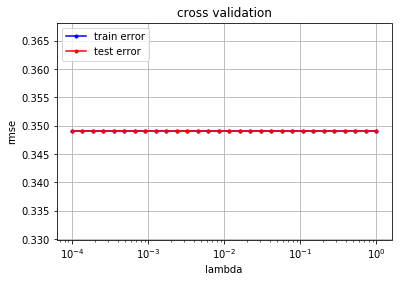

In [305]:
from auxiliary import *
tx = small_tx_train
y = small_labels
cross_validation_demo(y,tx)

## Testing

* **Test** the model with the weights computed from the different learning algorithms to find the best one

## Cross-validate

* the hyperparameters for each algorithm
    * `least_squares` 
    * `least_squares_GD` -> `gamma`
    * `least_squares_SGD` -> `gamma`, `batch_size`
    * `ridge_regression` -> `lambda_`
    * `logistic_regression` -> `gamma`
    * `reg_logistic_regression` -> `lambda_`, `gamma`
* Also, if we use other features (e.g. polynomial), we should CV those as well

## Results

* Plot the train / test accuracies for the best set of algorithm + parameters